In [1]:
%reload_ext autoreload
%autoreload 2

# Creating a prototype

After some preparation, we are now ready to try and build the core of the prototype.

As a reminder, the goal of this product is to take an input image **which we assume contains a sudoku grid** and "solve" it.

Before we get start coding, let's agree on some more details.

## Expected input

As written above, the input is an **image**. Let's add some more constraint and say that we are going to process only images in either JPEG or PNG format.
While this may seem arbitrary (there's no reason why it shouldn't work with other image formats), it is important to set some precise boundaries, at least at first, so that we can focus on the core part of the product, as in solving a sudoku, instead of potentially having to deal with issues linked to poorly supported file formats and whatnot.

Moreover, we also assume that somewhere in the image there is a sudoku grid. Since a reasonable use case for the tool is imagining someone taking a picture of a sudoku grid on their phone from say a magazine, we can also assume that it's going to be in black or dark ink on a white page. 

So far, nothing particularly surprising.

One thing that we will have to be relaxed about is the grid's position in the image: we can't really demand for the grid to be perfectly aligned with the edges of the image (i.e. parallel to it), so we'll have to account for the fact that it will likely be slightly rotated.

Something like this:

<img src="../../sample_data/sudoku_real_1.jpeg" alt="drawing" width="400"/>

## Designing the solution

Now we have to figure out _how_ exactly to do the thing. That is, this is a somewhat complex problem that requires multiple steps, we need to make a list of what these steps are, and arrange them in order.

I personally find useful starting _from the end_, i.e. the desired result, and walk my way back to the input. This is because it usually makes it easier to avoid branching out to dead ends.

Solving the sudoku, once the input is **in a suitable format**, is actually quite easy, we can write (or even better, copy from somewhere else) an algorithm that takes the original grid configuration, with missing numbers, and returns the actual solution. Let's assume that we have that! (we do)

What about the "suitable format"? Well, it's a 9 x 9 grid, and there are several ways to represent that data structure in Python. Lists are going to do the trick here: each **row** of the grid will be a list with 9 elements, whose content will be either a digit from 1 to 9 if the number in the corresponding image is filled, 0 otherwise. We will collect these 9 lists (one for each row) in a list as well.

So for instance, for the image above, the representation would be the following:

```Python
grid_list = [
    [1, 0, 0,  0, 8, 3,  0, 0, 0],
    [0, 0, 0,  9, 0, 0,  6, 2, 0],
    [0, 0, 2,  0, 0, 0,  0, 0, 5],
    
    [0, 0, 8,  0, 0, 7,  0, 0, 1],
    [0, 5, 0,  0, 0, 0,  0, 9, 0],
    [3, 0, 0,  1, 0, 0,  2, 0, 0],
    
    [6, 0, 0,  0, 0, 0,  1, 0, 0],
    [0, 8, 7,  0, 0, 1,  0, 0, 0],
    [0, 0, 0,  7, 9, 0,  0, 0, 8],
]
```

Now comes the interesting bit: how do we fill those numbers? Automatically, I mean, starting from the image.

From the previous labs, we have an algorithm that takes a 28 x 28 image containing a digit and detect its content. That seems like a good starting point, but the input image contains the entire grid (plus more stuff around it), it may be rotated, the size is likely wrong etc.
We need to go from the raw image to **eighty-one (9 x 9) separate images**, each containing an isolated cell. We will need to:

1. Locate the grid within the image, so that we can remove everything else around it.
2. "Cancel" the effect of rotation and shear, so that we have a square image containing only the grid.
3. Split the square image from the previous step in 81 individual squares.
4. Resize those squares so that they become 28 x 28 pixels.

At some point in there, we may also do some additional cleaning to remove noise, leftover lines and weird stuff that we don't want.

Now the input is in the correct format to be ingested by our classifier: we run it for all 81 cells and save the results in the appropriate list element.

Done!

## Implementation

Now we have to go and implement the steps we described above, this time of course starting from the beginning, that is the **raw image**.

### Image preprocessing

We begin by reading the image, displaying it and doing some initial preprocessing. We'll use a bunch of auxiliary function that have already been implemented, I'll briefly explain what they do when we first use them.

In [2]:
# We start by reading and displaying the image we have shown above, this time reading it with a library so that we have it available as a Python variable.
img_path = "../../sample_data/sudoku_real_1.jpeg"

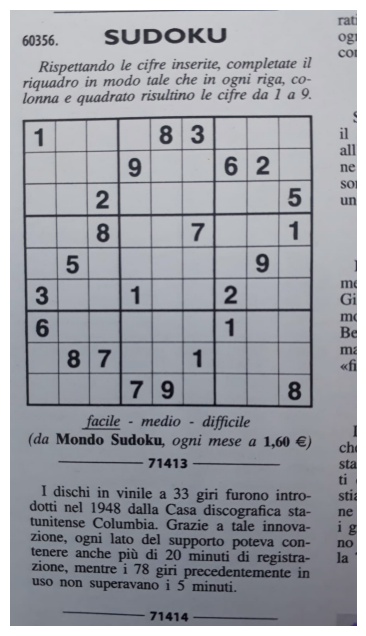

In [3]:
# We're going to use the OpenCV library, which contains many useful functions for handling images (CV stands for Computer Vision).

import cv2 # This imports the OpenCV library
import matplotlib.pyplot as plt

img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.axis('off') # Removes axis
plt.imshow(img);

This is the raw image. Let's take a look at how it's actually represented as a Python object.

In [4]:
# Let's start with the type
print(type(img))

<class 'numpy.ndarray'>


Looks like it's a **numpy array**, makes sense. Let's check its shape.

In [5]:
# Print the array's shape
print(img.shape)

(1600, 900, 3)


Here we already get some extra information: this array has **three** dimensions: height, width and _channels_.
This means that the image was read as a color (RGB) image, which means that there are three separate height X width 2D arrays stacked on top of each other, each representing one of the three channels (**R**ed, **G**reen and **B**lue).

In [6]:
# We can also get some information by calling the shell command `file`.
# Using `!` at the beginning of a row we can run shell commands.
!file {img_path}

../../sample_data/sudoku_real_1.jpeg: JPEG image data, JFIF standard 1.01


The first simple bit of preprocessing that we'll do is turn the image into a grayscale one, using a utility function from OpenCV.

In [7]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

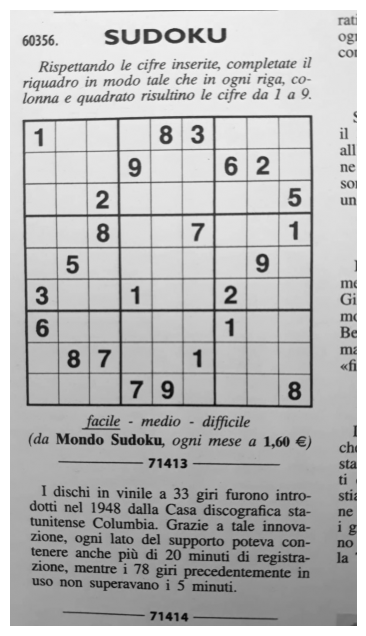

In [8]:
plt.figure(figsize=(8, 8))
plt.axis('off') # Removes axis

# We have to specify a color map using the cmap argument, because the default choice
# looks like garbage (you can try it out by removing that argument)
plt.imshow(img_gray, cmap='gray'); 

You should be able to tell the difference from the previous image.
We can also verify that the image is now a 2D array by printing its shape.

In [9]:
# Print the array's shape
print(img_gray.shape)

(1600, 900)


Notice how there are only two numbers now, there is no longer the `3` at the end.

We will now proceed to do some more aggressive preprocessing, using an auxiliary function called `pre_process_image`. The main goal of this function is to _binarize_ the image, that is turn it from a grayscale to a simpler representation where every pixel is either black or white.

Binarization happens by _thresholding_ the image, which means choosing a value of pixel intensity and setting to some high value (like 255) all pixels that have an intensity equal or greater than that, and to zero everything else.

We also invert the colors, mainly because the dataset the model was trained on also had white digits on a black background.

This is required for the next steps.

In [10]:
from phd_school.utils.data_preprocessing import pre_process_image

pre_preocessed = pre_process_image(img_gray)

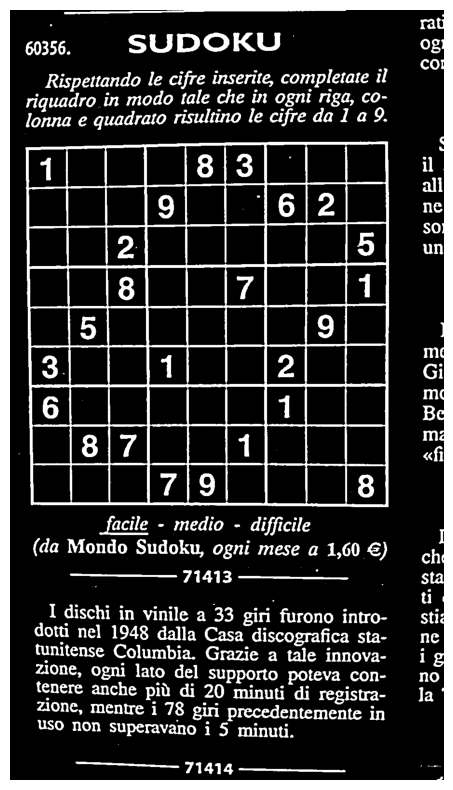

In [11]:
plt.figure(figsize=(10, 10))
plt.axis('off') # Removes axis

plt.imshow(pre_preocessed, cmap='gray');

### Isolate area of the grid

Now comes the tricky part: isolating the grid from the rest of the image.

To do that, we apply a neat trick: assuming the external edges of the grid form the **largest contour** present in the image, we simply compute **all** contours present in the image and then sort them by area, and we pick the largest one.

Moreover, since we know that this contour will be a square, we can also extract the coordinates of the 4 corners.

Details of how this is peformed can be found in function `find_corners_of_largest_polygon`.

Once we have the four corners, it's relatively easy to go ahead and crop the image so that only the grid is visible.
In addition to that, we apply one more transformation to correct for any minor rotation in the image, so that the grid's sides are aligned with the image's edges.

In [12]:
from phd_school.utils.data_preprocessing import crop_and_warp, find_corners_of_largest_polygon

# Find the 4 corners of the external grid
corners = find_corners_of_largest_polygon(pre_preocessed)

# Crop the image and compensate for warp
cropped = crop_and_warp(pre_preocessed, corners)

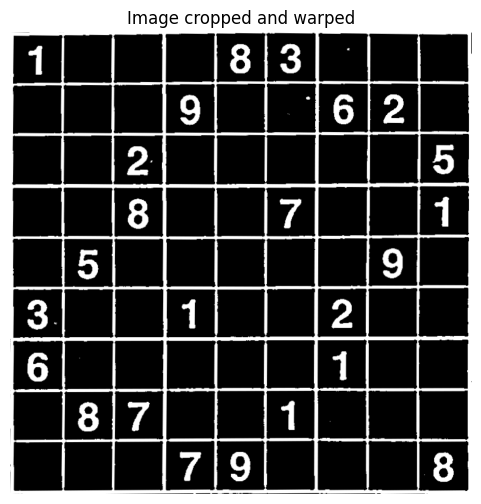

In [13]:
plt.figure(figsize=(6, 6))
plt.axis('off') # Removes axis
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

### Detect digits

The hard work is done!

Now it's just a matter of detecting the digits in the individual cells. 
The classifier we trained in the first lab takes a single image as input, so we're going to slice the grid in 81 approximately equal squares, each one showing one of the cells in the original image.
At this point, doing that is pretty straightforward, because we can rely on the fact that the image we obtained at the previous step is **square** and **aligned**.

In [14]:
def slice_grid(grid, i, j, W):
    """
    Assuming grid is an array representing the image, return a single square
    based on its coordinates (which start from 0). 
    """
    
    i_start = i * W
    i_end = i_start + W
    
    j_start = j * W
    j_end = j_start + W
        
    aa = grid[i_start:i_end, j_start:j_end]
    return aa

In [15]:
# We're going to need the estimated _single cell_'s width.
# Since we know the grid is 9 x 9 cells, and it's a square, we can simply compute that by dividing the image's width by 9
w, h = cropped.shape

W = w//9

In [16]:
# Just to make sure that it works and returns what we expect, let's try to recover the square with the 9 in the 2nd row, 4th column
# Remember that indexes start from 0, and the first one refers to rows, and the second one to columns.
test_cell = slice_grid(cropped, 1, 3, W)

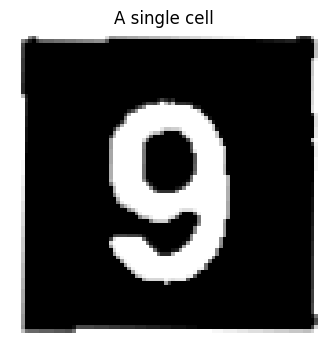

In [17]:
plt.figure(figsize=(4, 4))
plt.axis('off') # Removes axis
plt.imshow(test_cell, cmap='gray')
plt.title("A single cell");

Just to be on the safe side, we want to remove also the leftover white at the image's edges (from the sudoku grid lines)

In [18]:
from phd_school.utils.data_preprocessing import remove_stuff

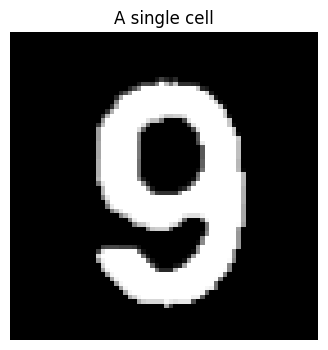

In [19]:
cleaned_test_cell = remove_stuff(test_cell)

plt.figure(figsize=(4, 4))
plt.axis('off') # Removes axis
plt.imshow(cleaned_test_cell, cmap='gray')
plt.title("A single cell");

Looks like it's working as intended. Let's try our trained classifier on it.

In [20]:
import pickle
from pathlib import Path

ARTIFACTS_DIR = "../artifacts"

best_model_path = Path(ARTIFACTS_DIR) / 'best_model_sklearn.pkl'
with open(best_model_path, 'rb') as f:
    best_model_sklearn = pickle.load(f) 

# Print the type, just to be sure. 
# This might be different depending on which model you chose in the first lab, but should have 'sklearn' somewhere.
print(type(best_model_sklearn))

<class 'sklearn.pipeline.Pipeline'>


In [21]:
from model_wrapper import TrainedSklearnModelWrapper

wrapped_classifier = TrainedSklearnModelWrapper(best_model_sklearn)

# We can't actually use the classifier on the sliced cell directly, since its input is expected to be the unraveled 784-long 1D array.
# We need to first resize the cell, and then pass the unraveled version.

resized = cv2.resize(test_cell, (28, 28), interpolation = cv2.INTER_AREA)

# This is a sanity check, raises an error if the shape is not the expected one.
assert resized.shape == (28, 28)

predicted_digit = wrapped_classifier.predictOne(resized.ravel())

print(f"Predicted digit was {predicted_digit}")

Predicted digit was 1


In [25]:
# If you want to try other cells, it's useful to wrap the entire process (starting from the pre-processed grid) in a function
def predict_cell(cropped, wrapped_classifier, i, j, W=W, ravel=True):

    test_cell = slice_grid(cropped, i, j, W)
    cleaned = remove_stuff(test_cell)
    resized = cv2.resize(cleaned, (28, 28), interpolation = cv2.INTER_AREA)
    if ravel:
        predicted_digit = wrapped_classifier.predictOne(resized.ravel())
    else:
        predicted_digit = wrapped_classifier.predictOne(resized)
    print(f"Predicted digit was {predicted_digit}")

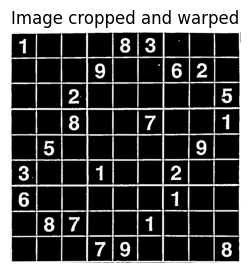

In [23]:
# And here's the grid again, for reference so that you don't have to scroll up and down

plt.figure(figsize=(3, 3))
plt.axis('off') # Removes axis
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

In [28]:
# Change the values of i and j here and play around with it
i, j = 7, 2
predict_cell(cropped, wrapped_classifier, i, j, W=W)

Predicted digit was 2


At this point, you probably have realized that there's something fishy going on.

The classifier seemed to work quite well on the dataset's data, achieving a very high accuracy, so how comes it does not seem to work as well (or at all) when we use it on a real image?

Let's take a break and come back to this!

In [56]:
from model import LitClassification

In [57]:
model = LitClassification.load_from_checkpoint("best_model.ckpt")
model.eval();

In [58]:
from model_wrapper_complete import TrainedTorchModelWrapper

In [59]:
wrapped_classifier_torch = TrainedTorchModelWrapper(model)

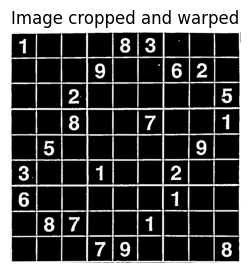

In [60]:
# And here's the grid again, for reference so that you don't have to scroll up and down

plt.figure(figsize=(3, 3))
plt.axis('off') # Removes axis
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

In [64]:
# Change the values of i and j here and play around with it
i, j = 0, 0 # 1
# i, j = 0, 4 # 8
# i, j = 0, 5 # 3
# i, j = 1, 3 # 9
# i, j = 1, 6 # 6
predict_cell(cropped, wrapped_classifier_torch, i, j, W=W, ravel=False)

Predicted digit was 5


In [ ]:
1/0

In [ ]:
1/0

In [ ]:
from phd_school.models import get_model
import torch

In [ ]:
device = 'cpu'

net = get_model("resnet101", pretrained=False).to(device)
model_path = Path("../models/") / "resnet101_allfonts_mnist.pth"

net.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
net = net.to(device)

In [ ]:
from model_wrapper_complete import TrainedTorchModelWrapper

In [ ]:
wrapped_classifier_torch = TrainedTorchModelWrapper(net)

In [ ]:
from phd_school.utils.classifier import smart_classify

In [ ]:
# test_cell = slice_grid(cropped, i, j, W)
# resized = cv2.resize(test_cell, (28, 28), interpolation = cv2.INTER_AREA)

aa = slice_grid(cropped, i, j, W)

bb = aa.astype(float)/255

# Isolate digit from rest of the cell
out = remove_stuff(bb)

# Resize to 28x28
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
# digits.append(smart_classify(resized, net, conf_threshold=0.9))

smart_classify(resized, net, conf_threshold=0.9, device=device)

In [ ]:
test_cell

In [ ]:
1/0

In [ ]:
2

In [ ]:
digits = list()

for i in range(9):
    
    for j in range(9):
        
        # Slice a cell from the original image
        aa = slice_grid(cropped_t, i, j, W)
        
        bb = aa.astype(float)/255

        # Isolate digit from rest of the cell
        out = remove_stuff(bb)
        
        # Resize to 28x28
        resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
        digits.append(smart_classify(resized, net, conf_threshold=0.9))

In [ ]:
def convert(d):
    if d == ' ':
        return 0
    else:
        return int(d)

In [ ]:
from phd_school.utils.data_preprocessing import crop_and_warp, find_corners_of_largest_polygon, pre_process_image, remove_stuff

In [ ]:
plt.imsave("cropped.png", cropped, cmap='gray')


In [ ]:
_, cropped_t = cv2.threshold(cropped,127,255,cv2.THRESH_TOZERO)

In [ ]:
cropped = cropped_t

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_t, cmap='gray')
plt.title("After thresholding");

In [ ]:
from sudoku_solver import print_board, solve_array

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(255-cropped, cmap='gray')
plt.title("The original grid");

In [ ]:
digits_int = np.array([convert(d) for d in digits])

digits_int = digits_int.reshape((9, 9))

In [ ]:
digits_list = [list(ll) for ll in list(digits_int)]

In [ ]:
print_board(digits_list)

In [ ]:

digits_list = list(digits_list)

solve_array(digits_list)

In [ ]:
print_board(digits_list)

## DEBUG

In [ ]:
# Coordinates in the natural system (row, column values from 1 to 9)
coordinates = 9, 5

In [ ]:
i, j = coordinates
i -= 1
j -= 1

In [ ]:
aa = slice_grid(cropped, i, j, W)
aa = aa.astype(np.float32)/255
plt.figure(figsize=(10,10))
plt.imshow(aa, cmap='gray')

In [ ]:
plt.imsave("one_cell_dirty.png", aa, cmap='gray')

In [ ]:
out = remove_stuff(aa)
# out = aa

plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')
plt.title("Remove artifacts at the border");

In [ ]:
plt.imsave("one_cell_clean.png", out, cmap='gray')

In [ ]:
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)

In [ ]:
plt.imsave("one_cell_resized.png", resized, cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(resized, cmap='gray')
plt.title("Resize image to 28 x 28 pixels");

In [ ]:
(resized != resized.min()).sum()

In [ ]:
smart_classify(resized, net, debug=True)